In [1]:
import os
import time

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16, ResNet50V2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2

In [ ]:
!unzip "/content/drive/My Drive/Datasets/emergency/train_SOaYf6m.zip" -d "/content/dataset"

In [128]:
train = pd.read_csv("/content/dataset/train.csv")
test = pd.read_csv("/content/dataset/test.csv")

print("Train set size: ", len(train))
print("Test set size: ", len(test))
print("\nTrain set value counts:\n", train["emergency_or_not"].value_counts())

Train set size:  1646
Test set size:  706

Train set value counts:
 0    965
1    681
Name: emergency_or_not, dtype: int64


In [4]:
train_image = []
for i in range(train.shape[0]):
    img = image.load_img('/content/dataset/images/'+train['image_names'][i], target_size=(224,224), grayscale=False)
    img = image.img_to_array(img)
    img *= 1./255
    train_image.append(img)
X = np.array(train_image)
print("Train set size: ", len(X)) # To check if the numbers match

test_image = []
for i in range(test.shape[0]):
    img = image.load_img('/content/dataset/images/'+test['image_names'][i], target_size=(224,224), grayscale=False)
    img = image.img_to_array(img)
    img *= 1./255
    test_image.append(img)
X_test = np.array(test_image)
print("Test set size: ", len(X_test))

Train set size:  1646
Test set size:  706


In [5]:
def display_examples(images):
    
    fig = plt.figure(figsize=(16,12))
    for i in range(20):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
    plt.show()

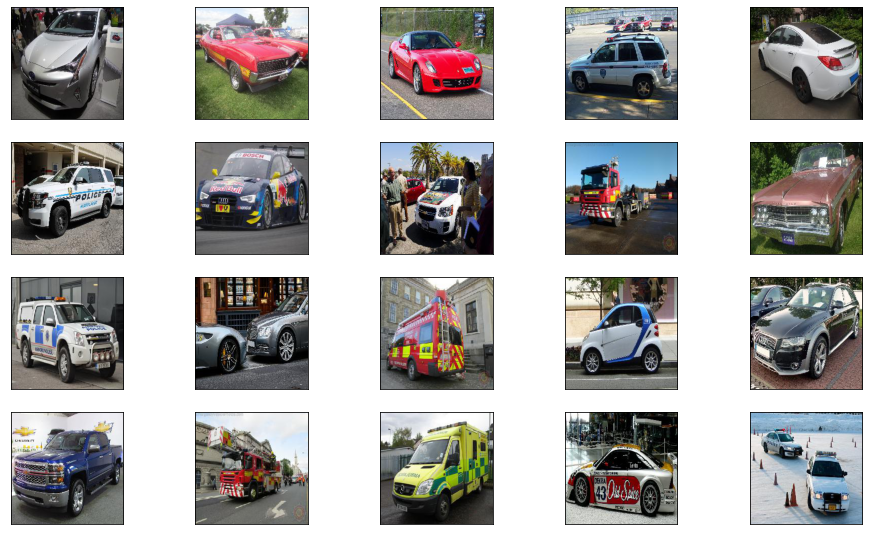

In [6]:
display_examples(X)

In [7]:
y = train["emergency_or_not"].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

In [8]:
image_datagen = ImageDataGenerator(shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

image_datagen.fit(X_train)

In [9]:
model = Sequential()

model.add(Conv2D(32, (3,3), padding="valid", activation="relu", input_shape=(224, 224, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, (3,3), padding="valid", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, (3,3), padding="valid", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128, (3,3), padding="valid", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))

model.add(Flatten())
model.add(Dense(64, activation="relu", kernel_initializer="uniform"))
model.add(Dropout(0.2))
model.add(Dense(64, activation="relu", kernel_initializer="uniform"))
model.add(Dropout(0.2))

model.add(Dense(1, kernel_initializer="uniform",activation="sigmoid"))

In [16]:
checkpoint_loss = ModelCheckpoint("weights_loss.hdf5", monitor="val_loss", save_best_only=True)
checkpoint_acc = ModelCheckpoint("weights_acc.hdf5", monitor="val_accuracy", save_best_only=True)
early_stopping = EarlyStopping(monitor="val_accuracy", patience=10)
reduce_lr = ReduceLROnPlateau(monitor="val_accuracy", patience=2, verbose=1)
callbacks= [checkpoint_loss, checkpoint_acc, early_stopping, reduce_lr]

In [11]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 222, 222, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 109, 109, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        3

In [12]:
history = model.fit(image_datagen.flow(X_train, y_train, batch_size=32), epochs=50, validation_data=(X_val, y_val), callbacks=callbacks)

Epoch 1/50
47/47 [==============================] - 16s 345ms/step - loss: 0.5199 - accuracy: 0.7373 - val_loss: 0.7017 - val_accuracy: 0.5879 - lr: 0.0010
Epoch 2/50
47/47 [==============================] - 16s 333ms/step - loss: 0.4061 - accuracy: 0.8217 - val_loss: 0.7308 - val_accuracy: 0.5879 - lr: 0.0010
Epoch 3/50
47/47 [==============================] - ETA: 0s - loss: 0.3539 - accuracy: 0.8393
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
47/47 [==============================] - 15s 329ms/step - loss: 0.3539 - accuracy: 0.8393 - val_loss: 1.4116 - val_accuracy: 0.5879 - lr: 0.0010
Epoch 4/50
47/47 [==============================] - 15s 329ms/step - loss: 0.2993 - accuracy: 0.8737 - val_loss: 1.3457 - val_accuracy: 0.5879 - lr: 1.0000e-04
Epoch 5/50
47/47 [==============================] - ETA: 0s - loss: 0.2565 - accuracy: 0.8926
Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
47/47 [==========================

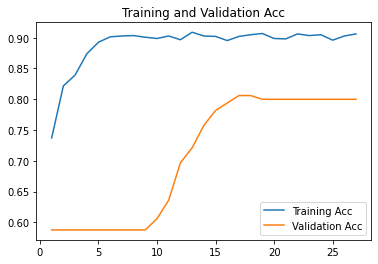

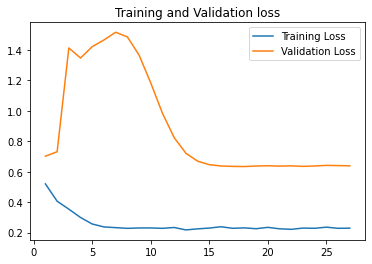

In [13]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc,label = "Training Acc")
plt.plot(epochs, val_acc ,label = "Validation Acc")
plt.title("Training and Validation Acc")
plt.legend()

plt.figure()

plt.plot(epochs,loss,label="Training Loss")
plt.plot(epochs,val_loss,label="Validation Loss")
plt.title("Training and Validation loss")
plt.legend()

plt.show()

In [14]:
model.load_weights("weights_loss.hdf5")
model.evaluate(X_val, y_val)

6/6 [==============================] - 0s 19ms/step - loss: 0.6336 - accuracy: 0.8061


[0.6336262822151184, 0.8060606122016907]

In [17]:
model.load_weights("weights_acc.hdf5")
model.evaluate(X_val, y_val)

6/6 [==============================] - 0s 20ms/step - loss: 0.6346 - accuracy: 0.8061


[0.6345529556274414, 0.8060606122016907]

In [18]:
prediction = model.predict_classes(X_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [20]:
def predict_save(test_set, file, col, modell):
    predictions = modell.predict_classes(test_set)
    
    file[col] = predictions
    if os.path.exists("preds.csv"):
        file.to_csv("preds_{}.csv".format(int(time.time())), header=True, index=False)
    else:
        file.to_csv("preds.csv", header=True, index=False)
    print("Saved.")

sample = pd.read_csv("/content/drive/My Drive/Datasets/emergency/sample_submission_yxjOnvz.csv")

In [21]:
predict_save(X_test, sample, "emergency_or_not", model)

Saved.


In [22]:
base_model = ResNet50V2(include_top=False, weights="imagenet", input_shape=(224,224,3), pooling="avg")
base_model.summary()

94674944/94668760 [==============================] - 2s 0us/step
Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
________________________

In [23]:
model2 = Sequential()

model2.add(base_model)
model2.add(Dense(64, activation = "relu", kernel_initializer="uniform"))
model2.add(Dropout(0.1))

model2.add(Dense(64, activation= "relu", kernel_initializer="uniform"))
model2.add(Dropout(0.1))

model2.add(Dense(32, activation= "relu", kernel_initializer="uniform"))
model2.add(Dropout(0.1))

model2.add(Dense(1, activation="sigmoid",kernel_initializer="uniform"))

base_model.trainable = False
model2.summary()
model2.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 2048)              23564800  
_________________________________________________________________
dense_3 (Dense)              (None, 64)                131136    
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)               

In [24]:
history = model2.fit(image_datagen.flow(X_train, y_train, batch_size=32, shuffle=False), epochs=50, validation_data=(X_val, y_val), callbacks=callbacks)

Epoch 1/50
47/47 [==============================] - 18s 383ms/step - loss: 0.4244 - accuracy: 0.8305 - val_loss: 0.2746 - val_accuracy: 0.9152 - lr: 0.0010
Epoch 2/50
47/47 [==============================] - 17s 364ms/step - loss: 0.1621 - accuracy: 0.9419 - val_loss: 0.2131 - val_accuracy: 0.9394 - lr: 0.0010
Epoch 3/50
47/47 [==============================] - 16s 350ms/step - loss: 0.1425 - accuracy: 0.9500 - val_loss: 0.2186 - val_accuracy: 0.9333 - lr: 0.0010
Epoch 4/50
47/47 [==============================] - ETA: 0s - loss: 0.1336 - accuracy: 0.9575
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
47/47 [==============================] - 16s 346ms/step - loss: 0.1336 - accuracy: 0.9575 - val_loss: 0.2302 - val_accuracy: 0.9333 - lr: 0.0010
Epoch 5/50
47/47 [==============================] - 16s 349ms/step - loss: 0.1110 - accuracy: 0.9649 - val_loss: 0.2239 - val_accuracy: 0.9333 - lr: 1.0000e-04
Epoch 6/50
47/47 [==============================] - 

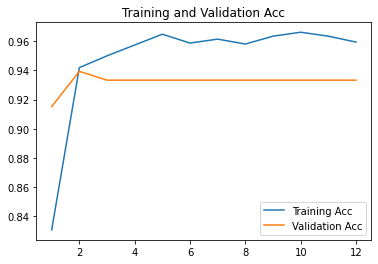

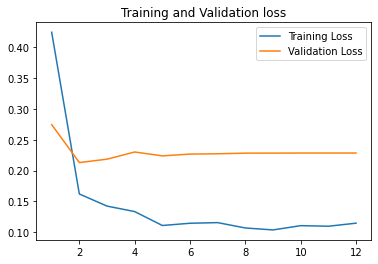

In [127]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc,label = "Training Acc")
plt.plot(epochs, val_acc ,label = "Validation Acc")
plt.title("Training and Validation Acc")
plt.legend()

plt.figure()

plt.plot(epochs,loss,label="Training Loss")
plt.plot(epochs,val_loss,label="Validation Loss")
plt.title("Training and Validation loss")
plt.legend()

plt.show()

In [26]:
model2.load_weights("weights_loss.hdf5")
model2.evaluate(X_val, y_val)

6/6 [==============================] - 0s 82ms/step - loss: 0.2131 - accuracy: 0.9394


[0.21306996047496796, 0.939393937587738]

In [27]:
model2.load_weights("weights_acc.hdf5")
model2.evaluate(X_val, y_val)

6/6 [==============================] - 0s 80ms/step - loss: 0.2131 - accuracy: 0.9394


[0.21306996047496796, 0.939393937587738]

In [28]:
predict_save(X_test, sample, "emergency_or_not", model2)

Saved.


In [29]:
model2.save('my_model.h5')

In [ ]:
model3 = load_model("/content/my_model.h5") # just trying to calculate the runtime, i know it is pointless to save then load the model again

In [151]:
# Let's try some random images from google
def new_images(model, img_path):

    img_path = img_path

    img = image.load_img(img_path, target_size=(224,224), grayscale=False)
    org = img.copy()
    img = image.img_to_array(img)
    img *= 1./255
    img = np.expand_dims(img, axis=0)

    proba = model.predict(img)

    result = (proba > 0.5).astype("int32")

    if result == 1:
        label = "Emergency"

    else:
        label = "Not Emergency"

    plt.text(5, 16, s=label, bbox=dict(facecolor="green", alpha=0.7), fontsize=12)
    plt.text(180, 214, s=round(float(proba), 3), bbox=dict(facecolor="green", alpha=0.7), fontsize=12)
    plt.xticks([])
    plt.yticks([])        
    plt.imshow(org, cmap=plt.cm.binary)
    plt.show()

In [ ]:
!wget https://www.glickfire.com/wp-content/uploads/slide_show/brat-slide-1217.jpg

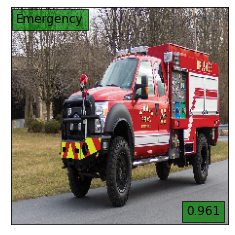

In [152]:
new_images(model3, "/content/brat-slide-1217.jpg")

In [ ]:
!wget https://aa-highway.com.sg/wp-content/uploads/2019/02/15712966659_2285d07d64_72dpi.jpg

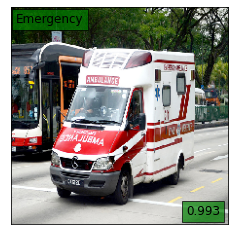

In [153]:
new_images(model3, "/content/try2.jpg")

In [ ]:
!wget https://i0.shbdn.com/photos/09/67/65/537096765y52.jpg

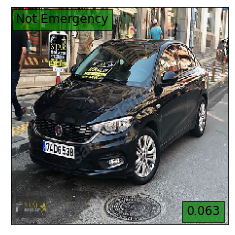

In [154]:
new_images(model3, "/content/try3.jpg")